/opt/homebrew/Caskroom/miniconda/base/envs/trading/lib/python3.8/site-packages/arctic/store/_pandas_ndarray_store.py:8: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
/Users/weiranzhou/Code/pysystemtrade/sysobjects/futures_per_contract_prices.py:35: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self._as_df = price_data_as_df


market price from 20373.5 to 25754.6, diff is 5381.0999999999985



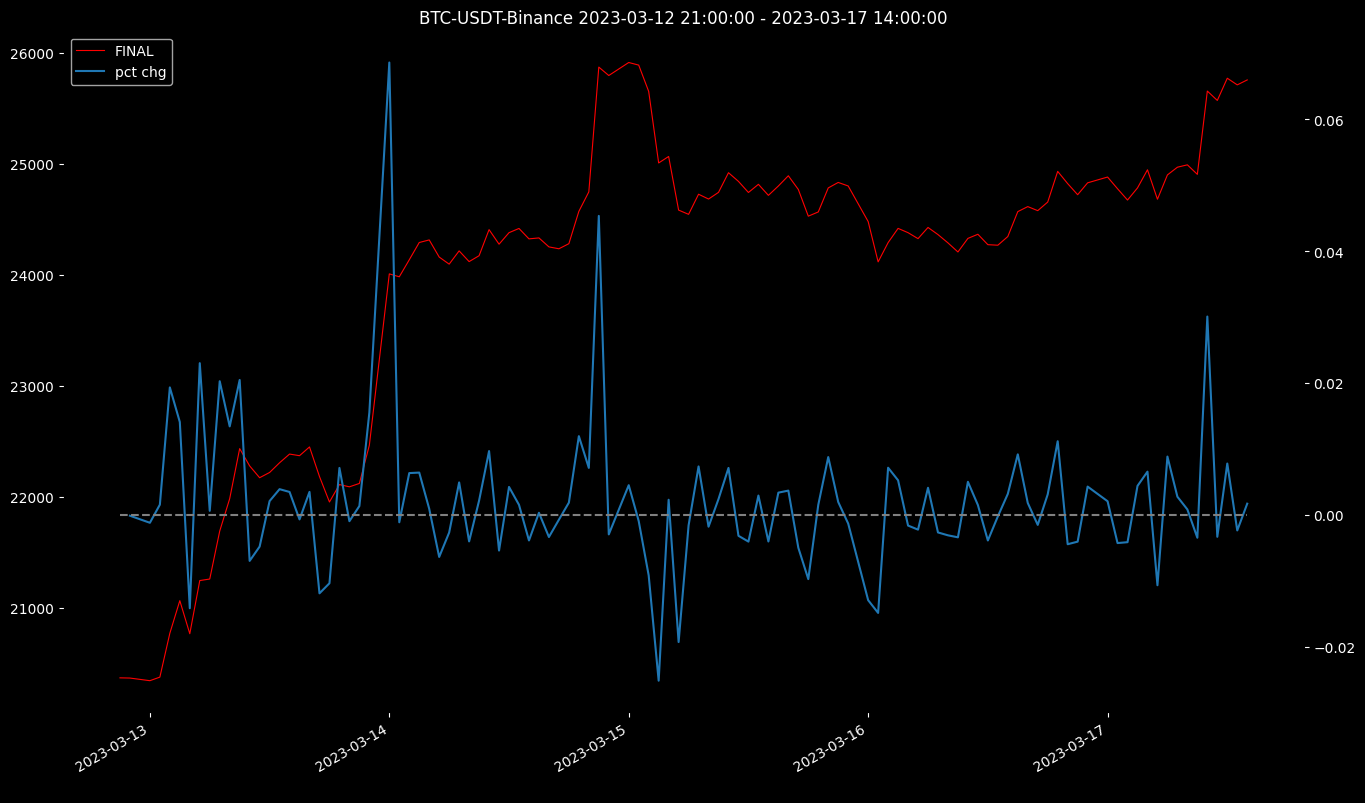

In [2]:
from sysquant.estimators.vol import robust_vol_calc
from paper.topic.common_import import *

def calc_ewmac_forecast(price, Lfast, Lslow=None):
    """
    Calculate the ewmac trading rule forecast, given a price and EWMA speeds
    Lfast, Lslow and vol_lookback

    """
    # price: This is the stitched price series
    # We can't use the price of the contract we're trading, or the volatility
    # will be jumpy
    # And we'll miss out on the rolldown. See
    # https://qoppac.blogspot.com/2015/05/systems-building-futures-rolling.html

    # price = price.resample("1B").last()

    if Lslow is None:
        Lslow = 4 * Lfast

    # We don't need to calculate the decay parameter, just use the span
    # directly
    fast_ewma = price.ewm(span=Lfast).mean()
    slow_ewma = price.ewm(span=Lslow).mean()
    raw_ewmac = fast_ewma - slow_ewma
    vol = robust_vol_calc(price.diff())
    return raw_ewmac / vol


data = system.data

instrument_code = 'BTC-USDT-Binance'
price = data.hourly_prices(instrument_code)
ewmac = calc_ewmac_forecast(price, 4, 16)
ewmac.columns = ['forecast']


from systems.accounts.account_forecast import pandl_for_instrument_forecast

capital = 19737.8
value_per_point = 1
risk_target = 0.5
target_abs_forecast = 1
vol, position, account = pandl_for_instrument_forecast(
    forecast=ewmac,
    price = price,
    capital = capital,
    value_per_point=value_per_point,
    risk_target = risk_target,
    target_abs_forecast = target_abs_forecast,
    SR_cost=0.1,
    delayfill=True
    )
position = position.round(2)

# RecentDys = 7 * 4 * 3
RecentDys = 5
end = pd.Timestamp.now()
start = end - np.timedelta64(RecentDys, "D")
period = (start, end)
price = select_period(price, period)
print('market price from {} to {}, diff is {}\n'.format(price.iloc[0], price.iloc[-1], price.iloc[-1] - price.iloc[0]))
position = select_period(position, period)

ax1 = price.plot(figsize=(16, 10), title='{} {} - {}'.format(instrument_code, price.index[0], price.index[-1]), color='r', lw=0.8)
ax2 = price.pct_change().rename('pct chg').plot(secondary_y=True)
_ = ax2.hlines(0, price.index[0], price.index[-1], colors='gray', linestyles='dashed')

# pnl = (position.shift(1) * price.diff()).rename('pnl')
# cum_pnl = pnl.cumsum().rename('cum_pnl')
# ax2 = cum_pnl.plot(secondary_y=True, alpha=0.3)
# drawdown = strategy_functions.drawdown(cum_pnl).rename('drawdown')
# ax2 = drawdown.plot(secondary_y=True, alpha=0.3)
# print('trading capital is {},  cum pnl is {}, max drawdown is {}\n'.format(capital, cum_pnl.iloc[-1], drawdown.min(skipna=True)))

lines = ax1.get_lines() + ax2.get_lines()
ax2.legend(lines, [line.get_label() for line in lines], loc='upper left')
plt.show()

In [ ]:
# vol = vol.rename('vol')
# position = position.rename('position')
# price.tail(24 * 10).plot(figsize=(15, 6), legend=True)
# (price*position).tail(24 * 10).plot(secondary_y=True, legend=True)
# plt.axhline(y=0, linewidth=2, color='r')
# plt.axhline(y=2000, linewidth=2, color='r')

# from syscore.pandas.frequency import resample_prices_to_business_day_index
# show(price)
# show(resample_prices_to_business_day_index(price).diff())
# account.curve().plot()
# plt.title('Profit and Loss')
# plt.ylabel('PnL')
# plt.xlabel('Time')

2023-03-15 00:00:00
2023-03-17 21:30:00
1.0863068369818751


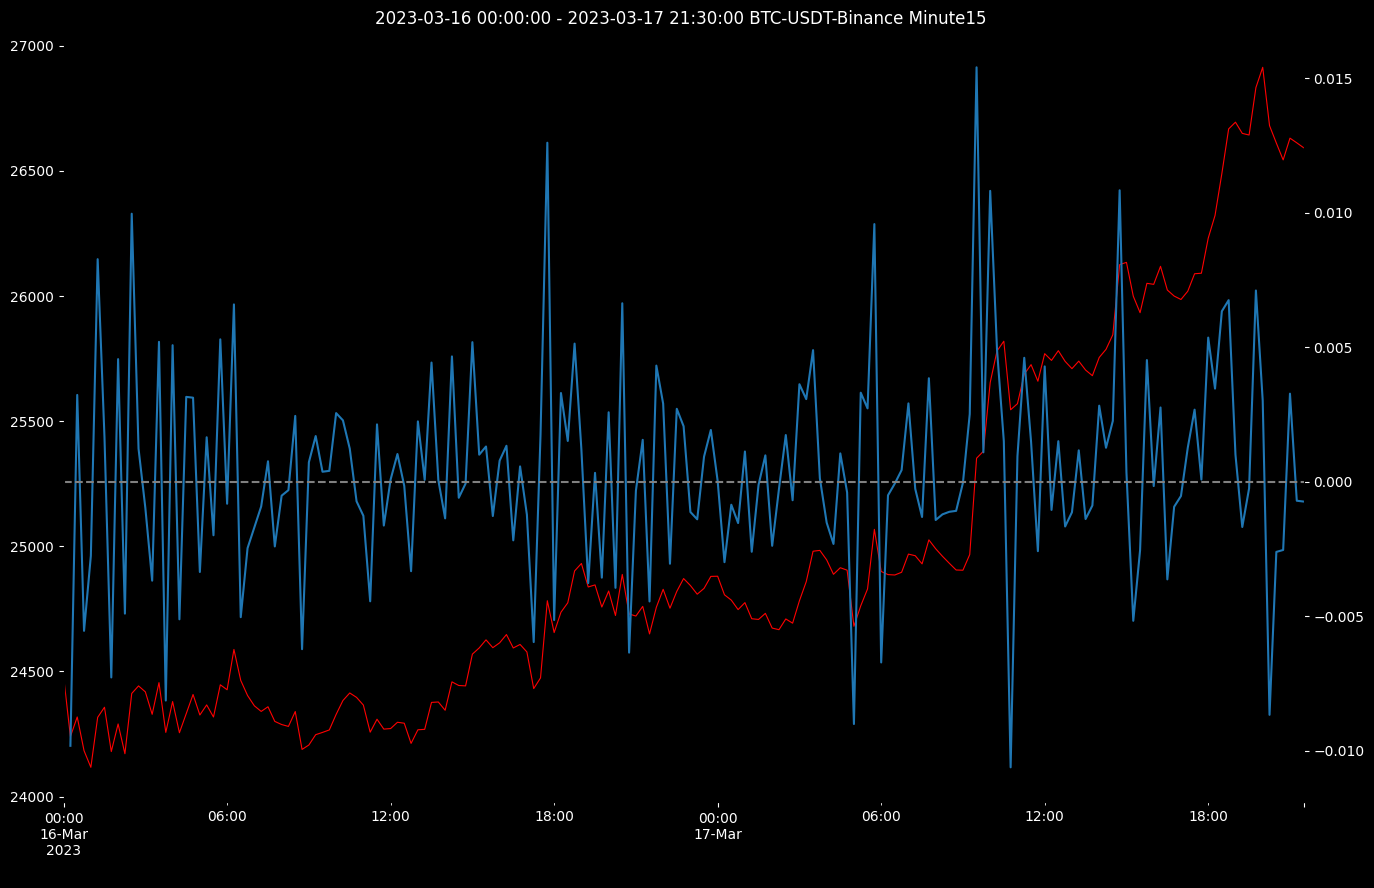

22.10375109645676


In [14]:
from syscore.fileutils import  resolve_path_and_filename_for_package
from paper.sysinit.scrape_okx_history_prices import update as observe_market
from paper.topic.common_import import *

instrument_code = 'BTC-USDT-Binance'
Fre = 'Minute15'
observe_market('BTC', '15m', '2023-03-15T00:00+08')
price = pd.read_csv(resolve_path_and_filename_for_package('{}.{}_{}.csv'.format('paper.sysinit.data.{}'.format('Binance'), Fre, instrument_code)), index_col=0, parse_dates=True)['FINAL']
price = select_period(price, ('2023-03-16', pd.Timestamp.now()))
_ = price.plot(figsize=(16, 10), title='{} - {} {} {} '.format(price.index[0], price.index[-1], instrument_code, Fre), color='r', lw=0.8)
print(price.iloc[-1] / price.iloc[0])

feature1 = price.pct_change().rename('pct chg')
ax2 = feature1.plot(secondary_y=True)
_ = ax2.hlines(0, price.index[0], price.index[-1], colors='gray', linestyles='dashed')
plt.show()
show(feature1.describe())
print(feature1.mean()/feature1.std() * np.sqrt(365 * 24*60/15))

# _ = sns.histplot(feature1, log_scale=(False, True), binwidth=0.004)
# plt.show()
